## CENÁRIO 02 - MODELO CORINGA 

IMPORTS

In [20]:
import pandas as pd
import simpy
import os
import re
from unidecode import unidecode
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import numpy as np
import matplotlib.patches as mpatches
from datetime import date, timedelta
from reportlab.lib.pagesizes import A4
from reportlab.pdfgen import canvas

### ETAPA 1 - Obtendo informações de tempo do Yamazumi

In [21]:


# OBTENDO TEMPOS POR ATIVIDADES DOS ARQUIVOS YAMAZUMI 
def get_process_times_from_csv(arquivo):
    """Lê um CSV Yamazumi, extrai os tempos por atividade e retorna um dicionário {atividade: tempo_em_segundos}."""
    
    def converter_tempo_para_segundos(tempo_str):
        if pd.isna(tempo_str) or not isinstance(tempo_str, str):
            return 0
        parts = str(tempo_str).split(':')
        try:
            if len(parts) == 3:
                h, m, s = map(int, parts)
                return h * 3600 + m * 60 + s
            elif len(parts) == 2:
                m, s = map(int, parts)
                return m * 60 + s
        except Exception:
            return 0
        return 0

    if not os.path.exists(arquivo):
        return {}

    df = pd.read_csv(arquivo, header=5, sep=';', encoding='latin1', on_bad_lines='skip')

    def normalizar_coluna(col):
        col = unidecode(col)
        col = col.upper()
        col = re.sub(r"[\"\'().\-\/]", "", col)
        col = re.sub(r"\s+", "_", col)
        return col.strip("_")

    df.columns = [normalizar_coluna(col) for col in df.columns]

    class_col = next((col for col in df.columns if 'CLASSIFICA' in col), None)
    if not class_col:
        return {}

    total_row = df[df[class_col] == 'Total'].copy()
    if total_row.empty:
        return {}

    start_col = df.columns.get_loc(class_col) + 1
    end_col = len(df.columns)
    try:
        end_col = df.columns.get_loc('COLUNA1')
    except KeyError:
        pass

    colunas_postos = df.columns[start_col:end_col]
    tempos_totais = total_row[colunas_postos].dropna(axis=1, how='all')
    tempos_formatados = tempos_totais.melt(var_name='Atividade', value_name='Tempo_str')
    tempos_formatados['Tempo_segundos'] = tempos_formatados['Tempo_str'].apply(converter_tempo_para_segundos)

    return pd.Series(tempos_formatados.Tempo_segundos.values, index=tempos_formatados.Atividade).to_dict()



### ETAPA 02: Criando dicionário de tempos por posto

In [22]:

# --- Dicionários ---
MODELOS_CSV = {
    "Accelo": {"baumuster": ["C951102", "C951104", "C951111"], "perna": [1], "tempos": "Yamazumi - Accelo.csv"},
    "Atego": {"baumuster":["C951500", "C951501", "C951511", "C951514", "C951530", "C951544"],"perna": [1], "tempos":"Yamazumi - Atego.csv"},
    "Atego (ATP)":{"baumuster": ["C968403", "C968114"], "perna": [1,2], "tempos":"Yamazumi - ATP.csv"}, 
    "Actros":{"baumuster": ["C963400", "C963403", "C963411", "C963414", "C963424", "C963425"], "perna": [2], "tempos":"Yamazumi - Actros.csv"},
    "Arocs": {"baumuster":["C964016", "C964216", "C964231", "C964416"], "perna": [2], "tempos":"Yamazumi - Arocs.csv"},
    "Axor (ATP +)":{"baumuster": ["C968150", "C968450", "C968453", "C968461", "C968475"], "perna":[2], "tempos": "Yamazumi - Actros.csv"}
}

ATIVIDADES_P1 = {'DIESEL':{'postos':['30A'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'ARREFEC':{'postos':['31A'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'REAPERTO':{'postos':['32A'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              '5AA_RODA':{'postos':['32C'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'ESTEPE':{'postos':['32C'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'APERTO_LE':{'postos':['32C'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'PNEU_LD':{'postos':['33A'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1}, 
              'PNEU_LE':{'postos':['33A'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'APERTO_LD':{'postos':['34A'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'GRADE':{'postos':['34A'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'MECACNICA_1':{'postos':['34A','38'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'MECACNICA_2':{'postos':['34A','38'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'ELACTRICA_1':{'postos':['32A','32C','33A'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'ELACTRICA_2':{'postos':['32A','32C','33A'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'CONTROLE':{'postos':['34A'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'MOTORISTA':{'postos':['38'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              'QUIS':{'postos':['38'],'modelos':['Accelo','Atego','Atego (ATP)'],'operadores':1},
              }

ATIVIDADES_P2 = {'PASSADISASSO':{'postos':['30B'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1},
              'ABASTECIMENTO':{'postos':['31B'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1},
              'CHINELEIRA':{'postos':['32B'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1},
              '5AA_RODA': {'postos':['32D'],'modelos':['Actros','Arocs', 'Axor (ATP +)','Atego (ATP)'],'operadores':2},
              'PNEU_LD':{'postos':['33B'],'modelos':['Actros','Arocs', 'Axor (ATP +)','Atego (ATP)'],'operadores':1}, 
              'PNEU_LE':{'postos':['33B'],'modelos':['Actros','Arocs', 'Axor (ATP +)','Atego (ATP)'],'operadores':1},
              'PARALAMA_LD': {'postos':['34B'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1},#mesmo operador que o de aperto_ld e le
              'PARALAMA_LE':{'postos':['34B'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1},
              'CONTROLE': {'postos':['34B'],'modelos':['Actros','Arocs', 'Axor (ATP +)','Atego (ATP)'],'operadores':1},
              'ELACTRICA_I':{'postos':['33B','34B','39'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1},
              'ELACTRICA_II':{'postos':['33B','34B','39'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1},
              'ELACTRICA_III':{'postos':['33B','34B','39'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':0},
              
              #Atividades da p1 que foram para a p2 também
              'DIESEL':{'postos':['30B'],'modelos':['Atego (ATP)'],'operadores':1},
              'ARREFEC':{'postos':['31B'],'modelos':['Atego (ATP)'],'operadores':1},
              'REAPERTO':{'postos':['32B'],'modelos':['Atego (ATP)'],'operadores':1},
              'ESTEPE':{'postos':['32D'],'modelos':['Atego (ATP)'],'operadores':1},
              'APERTO_LE':{'postos':['32D'],'modelos':['Atego (ATP)'],'operadores':1},
              'APERTO_LD':{'postos':['34B'],'modelos':['Atego (ATP)'],'operadores':1},
              'GRADE':{'postos':['34B'],'modelos':['Atego (ATP)'],'operadores':1},
              'MECACNICA_1':{'postos':['34B','39'],'modelos':['Atego (ATP)'],'operadores':1},
              'MECACNICA_2':{'postos':['34A','39'],'modelos':['Atego (ATP)'],'operadores':1},
              'ELACTRICA_1':{'postos':['34B','39'],'modelos':['Atego (ATP)'],'operadores':1},
              'ELACTRICA_2':{'postos':['34B','39'],'modelos':['Atego (ATP)'],'operadores':1},
              'MOTORISTA':{'postos':['39'],'modelos':['Atego (ATP)'],'operadores':1},
              'QUIS':{'postos':['39'],'modelos':['Atego (ATP)'],'operadores':1},
               }


In [23]:
def gerar_dicionario_postos(MODELOS_CSV, ATIVIDADES_P1, ATIVIDADES_P2, get_process_times_from_csv):
    """
    Gera o dicionário POSTOS por modelo, criando chaves separadas por perna quando necessário.
    - Ex.: 'Atego (ATP) P1' e 'Atego (ATP) P2' se perna == [1,2].
    - Para 'Atego (ATP)', a P2 é espelhada da P1 (mesmos tempos, mapeando 30A->30B, ..., 38->39).
    - Para os demais modelos, P1 segue regras P1 e P2 segue regras P2.
    """

    ordem_P1 = ['30A', '31A', '32A', '32C', '33A', '34A', '38']
    ordem_P2 = ['30B', '31B', '32B', '32D', '33B', '34B', '39']
    POSTOS = {}

    # --------- Helpers ---------
    def coerce_pernas(pernas):
        if isinstance(pernas, int):
            return [pernas]
        if isinstance(pernas, (list, tuple)):
            return list(pernas)
        return list(pernas)

    def t(atividade, tempos, ativ_dict):
        """tempo/operadores (0 se atividade não existe no dict da perna)."""
        if atividade not in ativ_dict:
            return 0.0
        ops = ativ_dict[atividade].get('operadores', 1) or 1
        return (tempos.get(atividade, 0.0)) / ops

    def avg(vals):
        vals = [v for v in vals if v is not None]
        return (sum(vals) / len(vals)) if vals else 0.0

    def tempos_p1(tempos, ativ_dict):
        """Aplica as fórmulas da PERNA 1 e retorna dict de tempos por posto P1."""
        # elétricas P1: (EL1/op + EL2/op)/2/3
        el_mix_p1 = avg([
            t('ELACTRICA_1', tempos, ativ_dict),
            t('ELACTRICA_2', tempos, ativ_dict)
        ]) / 3.0

        p_30A = t('DIESEL', tempos, ativ_dict)
        p_31A = t('ARREFEC', tempos, ativ_dict)
        p_32A = t('REAPERTO', tempos, ativ_dict) + el_mix_p1
        p_32C = (
            t('ESTEPE', tempos, ativ_dict) +
            avg([t('APERTO_LE', tempos, ativ_dict),
                 t('5AA_RODA', tempos, ativ_dict)]) +
            el_mix_p1
        )
        pneus_p1 = avg([
            t('PNEU_LE', tempos, ativ_dict),
            t('PNEU_LD', tempos, ativ_dict)
        ])
        p_33A = pneus_p1 + el_mix_p1

        mec_avg_p1 = avg([
            t('MECACNICA_1', tempos, ativ_dict),
            t('MECACNICA_2', tempos, ativ_dict)
        ]) / 2.0
        p_34A = t('APERTO_LD', tempos, ativ_dict) + t('GRADE', tempos, ativ_dict) + mec_avg_p1
        p_38  = t('MOTORISTA', tempos, ativ_dict) + t('QUIS', tempos, ativ_dict) + mec_avg_p1

        return {
            '30A': p_30A,
            '31A': p_31A,
            '32A': p_32A,
            '32C': p_32C,
            '33A': p_33A,
            '34A': p_34A,
            '38' : p_38
        }

    def tempos_p2(tempos, ativ_dict):
        """Aplica as fórmulas da PERNA 2 e retorna dict de tempos por posto P2."""
        # Elétrica P2: ((EL_I/op + EL_II/op + EL_III/op)/2)/3
        el_sum = (
            t('ELACTRICA_I', tempos, ativ_dict) +
            t('ELACTRICA_II', tempos, ativ_dict) +
            t('ELACTRICA_III', tempos, ativ_dict)
        )
        el_share = (el_sum / 2.0) / 3.0 if el_sum > 0 else 0.0

        p_30B = t('PASSADISASSO', tempos, ativ_dict)
        p_31B = t('ABASTECIMENTO', tempos, ativ_dict)
        p_32B = t('CHINELEIRA', tempos, ativ_dict)
        p_32D = t('5AA_RODA', tempos, ativ_dict)

        pneus_p2 = avg([
            t('PNEU_LE', tempos, ativ_dict),
            t('PNEU_LD', tempos, ativ_dict)
        ])
        p_33B = pneus_p2 + el_share

        paralamas_avg = avg([
            t('PARALAMA_LD', tempos, ativ_dict),
            t('PARALAMA_LE', tempos, ativ_dict)
        ])
        p_34B = paralamas_avg + t('CONTROLE', tempos, ativ_dict) + el_share

        p_39 = el_share

        return {
            '30B': p_30B,
            '31B': p_31B,
            '32B': p_32B,
            '32D': p_32D,
            '33B': p_33B,
            '34B': p_34B,
            '39' : p_39
        }

    # mapa para espelhar P1 -> P2 (para o Atego (ATP) P2)
    mapa_p1_p2 = {
        '30A': '30B',
        '31A': '31B',
        '32A': '32B',
        '32C': '32D',
        '33A': '33B',
        '34A': '34B',
        '38' : '39'
    }

    # --------- Loop principal ----------
    for modelo_nome, dados_modelo in MODELOS_CSV.items():
        pernas = coerce_pernas(dados_modelo.get("perna", []))
        tempos = get_process_times_from_csv(dados_modelo["tempos"])
        if not tempos:
            continue

        # Se o modelo tem P1, já calcule os tempos P1 (pode ser espelhado depois)
        tempos_p1_calc = None
        if 1 in pernas:
            tempos_p1_calc = tempos_p1(tempos, ATIVIDADES_P1)

        # Para cada perna deste modelo, gera uma chave separada
        for perna_atual in pernas:
            if perna_atual == 1:
                # P1: usa regras P1
                tempos_por_posto = tempos_p1_calc if tempos_p1_calc is not None else tempos_p1(tempos, ATIVIDADES_P1)
                ordem = ordem_P1
                chave = f"{modelo_nome} P1" if len(pernas) > 1 else modelo_nome

            else:
                # P2:
                if modelo_nome == "Atego (ATP)":
                    # ESPELHAR P1 → P2
                    if tempos_p1_calc is None:
                        tempos_p1_calc = tempos_p1(tempos, ATIVIDADES_P1)
                    tempos_por_posto = {mapa_p1_p2[p1]: v for p1, v in tempos_p1_calc.items() if p1 in mapa_p1_p2}
                    ordem = ordem_P2
                else:
                    # Demais modelos P2: usa regras P2
                    tempos_por_posto = tempos_p2(tempos, ATIVIDADES_P2)
                    ordem = ordem_P2

                chave = f"{modelo_nome} P2" if len(pernas) > 1 else modelo_nome

            # Monta saída ordenada desta perna
            postos_ordenados = {}
            for posto in ordem:
                if posto in tempos_por_posto and tempos_por_posto[posto] > 0:
                    postos_ordenados[posto] = {"tempo_tot": tempos_por_posto[posto], "perna": [perna_atual]}

            POSTOS[chave] = postos_ordenados

    return POSTOS

In [24]:
# def gerar_dicionario_postos(MODELOS_CSV, ATIVIDADES_P1, ATIVIDADES_P2, get_process_times_from_csv):
#     ordem_P1 = ['30A', '31A', '32A', '32C', '33A', '34A', '38']
#     ordem_P2 = ['30B', '31B', '32B', '32D', '33B', '34B', '39']
#     POSTOS = {}

#     # somente estes modelos espelham P1 quando rodarem na P2
#     MODELOS_ESPELHO_P2 = {'Atego (ATP)'}  # <-- apenas ele

#     # ----------------- Helpers -----------------
#     def _coerce_pernas(pernas):
#         if isinstance(pernas, int): return [pernas]
#         if isinstance(pernas, (list, tuple)): return list(pernas)
#         return list(pernas)

#     def t(atividade, tempos, ativ_dict):
#         if atividade not in ativ_dict:
#             return 0.0
#         ops = ativ_dict[atividade].get('operadores', 1) or 1
#         return (tempos.get(atividade, 0.0)) / ops

#     def avg(vals):
#         vals = [v for v in vals if v is not None]
#         return (sum(vals) / len(vals)) if vals else 0.0
#     # -------------------------------------------

#     for modelo_nome, dados_modelo in MODELOS_CSV.items():
#         pernas_modelo = _coerce_pernas(dados_modelo.get("perna", []))
#         tempos_atividade = get_process_times_from_csv(dados_modelo["tempos"])
#         if not tempos_atividade:
#             continue

#         for perna_atual in pernas_modelo:
#             if perna_atual == 1:
#                 ativ = ATIVIDADES_P1
#                 # P1
#                 p_30A = t('DIESEL', tempos_atividade, ativ)
#                 p_31A = t('ARREFEC', tempos_atividade, ativ)
#                 el_mix_p1 = avg([t('ELACTRICA_1', tempos_atividade, ativ),
#                                  t('ELACTRICA_2', tempos_atividade, ativ)]) / 3.0
#                 p_32A = t('REAPERTO', tempos_atividade, ativ) + el_mix_p1
#                 p_32C = (t('ESTEPE', tempos_atividade, ativ) +
#                          t('APERTO_LE', tempos_atividade, ativ) +
#                          t('5AA_RODA', tempos_atividade, ativ) +
#                          el_mix_p1)
#                 pneus_p1 = avg([t('PNEU_LE', tempos_atividade, ativ),
#                                 t('PNEU_LD', tempos_atividade, ativ)])
#                 p_33A = pneus_p1 + el_mix_p1
#                 mec_avg_p1 = avg([t('MECACNICA_1', tempos_atividade, ativ),
#                                   t('MECACNICA_2', tempos_atividade, ativ)]) / 2.0
#                 p_34A = t('APERTO_LD', tempos_atividade, ativ) + t('GRADE', tempos_atividade, ativ) + mec_avg_p1
#                 p_38 = t('MOTORISTA', tempos_atividade, ativ) + t('QUIS', tempos_atividade, ativ) + mec_avg_p1

#                 tempos_por_posto = {
#                     '30A': p_30A, '31A': p_31A, '32A': p_32A, '32C': p_32C,
#                     '33A': p_33A, '34A': p_34A, '38': p_38
#                 }

#             elif perna_atual == 2:
#                 if modelo_nome in MODELOS_ESPELHO_P2:
#                     # espelha regras/operadores da P1 e mapeia A->B/D
#                     ativ_p1 = ATIVIDADES_P1
#                     p_30A = t('DIESEL', tempos_atividade, ativ_p1)
#                     p_31A = t('ARREFEC', tempos_atividade, ativ_p1)
#                     el_mix_p1 = avg([t('ELACTRICA_1', tempos_atividade, ativ_p1),
#                                      t('ELACTRICA_2', tempos_atividade, ativ_p1)]) / 3.0
#                     p_32A = t('REAPERTO', tempos_atividade, ativ_p1) + el_mix_p1
#                     p_32C = (t('ESTEPE', tempos_atividade, ativ_p1) +
#                              t('APERTO_LE', tempos_atividade, ativ_p1) +
#                              t('5AA_RODA', tempos_atividade, ativ_p1) +
#                              el_mix_p1)
#                     pneus_p1 = avg([t('PNEU_LE', tempos_atividade, ativ_p1),
#                                     t('PNEU_LD', tempos_atividade, ativ_p1)])
#                     p_33A = pneus_p1 + el_mix_p1
#                     mec_avg_p1 = avg([t('MECACNICA_1', tempos_atividade, ativ_p1),
#                                       t('MECACNICA_2', tempos_atividade, ativ_p1)]) / 2.0
#                     p_34A = t('APERTO_LD', tempos_atividade, ativ_p1) + t('GRADE', tempos_atividade, ativ_p1) + mec_avg_p1
#                     p_38 = t('MOTORISTA', tempos_atividade, ativ_p1) + t('QUIS', tempos_atividade, ativ_p1) + mec_avg_p1

#                     tempos_por_posto = {
#                         '30B': p_30A, '31B': p_31A, '32B': p_32A, '32D': p_32C,
#                         '33B': p_33A, '34B': p_34A, '39': p_38
#                     }
#                 else:
#                     # P2 normal (sem espelho) — mantenha aqui suas fórmulas padrão de P2, se precisar
#                     ativ = ATIVIDADES_P2
#                     el_sum = (t('ELACTRICA_I', tempos_atividade, ativ) +
#                               t('ELACTRICA_II', tempos_atividade, ativ) +
#                               t('ELACTRICA_III', tempos_atividade, ativ) +
#                               t('ELACTRICA_1', tempos_atividade, ativ) +
#                               t('ELACTRICA_2', tempos_atividade, ativ))
#                     el_share = (el_sum / 2.0) / 3.0 if el_sum > 0 else 0.0
#                     p_30B = t('PASSADISASSO', tempos_atividade, ativ) + t('DIESEL', tempos_atividade, ativ)
#                     p_31B = t('ABASTECIMENTO', tempos_atividade, ativ) + t('ARREFEC', tempos_atividade, ativ)
#                     p_32B = t('CHINELEIRA', tempos_atividade, ativ) + t('REAPERTO', tempos_atividade, ativ)
#                     p_32D = t('5AA_RODA', tempos_atividade, ativ) + t('ESTEPE', tempos_atividade, ativ) + t('APERTO_LE', tempos_atividade, ativ)
#                     pneus_p2 = avg([t('PNEU_LE', tempos_atividade, ativ), t('PNEU_LD', tempos_atividade, ativ)])
#                     p_33B = pneus_p2 + el_share
#                     mec_avg_p2 = avg([t('MECACNICA_1', tempos_atividade, ativ), t('MECACNICA_2', tempos_atividade, ativ)]) / 2.0
#                     p_34B = avg([t('PARALAMA_LD', tempos_atividade, ativ), t('PARALAMA_LE', tempos_atividade, ativ)]) \
#                             + t('CONTROLE', tempos_atividade, ativ) + el_share \
#                             + t('APERTO_LD', tempos_atividade, ativ) + t('GRADE', tempos_atividade, ativ) + mec_avg_p2
#                     p_39 = el_share + mec_avg_p2 + t('MOTORISTA', tempos_atividade, ativ) + t('QUIS', tempos_atividade, ativ)

#                     tempos_por_posto = {
#                         '30B': p_30B, '31B': p_31B, '32B': p_32B, '32D': p_32D,
#                         '33B': p_33B, '34B': p_34B, '39': p_39
#                     }
#             else:
#                 continue

#             # saída ordenada
#             ordem = ordem_P1 if perna_atual == 1 else ordem_P2
#             postos_ordenados = {p: {"tempo_tot": tempos_por_posto[p], "perna": [perna_atual]}
#                                 for p in ordem if p in tempos_por_posto and tempos_por_posto[p] > 0}

#             chave = modelo_nome if len(pernas_modelo) == 1 else f"{modelo_nome} P{perna_atual}"
#             POSTOS[chave] = postos_ordenados

#     return POSTOS


In [25]:
POSTOS = gerar_dicionario_postos(MODELOS_CSV, ATIVIDADES_P1, ATIVIDADES_P2, get_process_times_from_csv)

In [26]:
POSTOS

{'Accelo': {'30A': {'tempo_tot': 253.0, 'perna': [1]},
  '31A': {'tempo_tot': 316.0, 'perna': [1]},
  '32A': {'tempo_tot': 354.0, 'perna': [1]},
  '32C': {'tempo_tot': 561.0, 'perna': [1]},
  '33A': {'tempo_tot': 369.0, 'perna': [1]},
  '34A': {'tempo_tot': 671.0, 'perna': [1]},
  '38': {'tempo_tot': 633.0, 'perna': [1]}},
 'Atego': {'30A': {'tempo_tot': 314.0, 'perna': [1]},
  '31A': {'tempo_tot': 314.0, 'perna': [1]},
  '32A': {'tempo_tot': 414.0, 'perna': [1]},
  '32C': {'tempo_tot': 544.5, 'perna': [1]},
  '33A': {'tempo_tot': 428.0, 'perna': [1]},
  '34A': {'tempo_tot': 646.0, 'perna': [1]},
  '38': {'tempo_tot': 633.0, 'perna': [1]}},
 'Atego (ATP) P1': {'30A': {'tempo_tot': 326.0, 'perna': [1]},
  '31A': {'tempo_tot': 330.0, 'perna': [1]},
  '32A': {'tempo_tot': 677.0, 'perna': [1]},
  '32C': {'tempo_tot': 815.0, 'perna': [1]},
  '33A': {'tempo_tot': 376.0, 'perna': [1]},
  '34A': {'tempo_tot': 650.0, 'perna': [1]},
  '38': {'tempo_tot': 633.0, 'perna': [1]}},
 'Atego (ATP) P2':

### ETAPA 03: Processamento da simulação 

In [27]:

 
TAKT_TIME = 5.5 * 60

TURN_DURATION = 14 * 3600
 
# defina a granularidade (1.0 = segundos; use 0.1 p/ décimos, 0.01 p/ centésimos)

TIME_GRID = 1.0
 
def q(t, base=TIME_GRID):

    # alinha t para a grade de tempo definida

    return round(t / base) * base
 
def processar_modelo(env, nome, modelo_nome, perna, postos_dict, recursos, log):

    for idx, (posto, dados) in enumerate(postos_dict.items()):

        tempo_tot = float(dados["tempo_tot"])

        recurso = recursos[posto]
 
        # requisita recurso

        req = recurso.request()

        instante_requisicao = env.now

        yield req
 
        # início real no posto (após obter o recurso), já quantizado

        inicio = q(env.now)

        tempo_proc = q(tempo_tot)
 
        # executa processamento com tempo quantizado

        yield env.timeout(tempo_proc)

        fim = q(env.now)
 
        # libera o recurso explicitamente

        recurso.release(req)
 
        # registra

        log.append({

            "modelo": modelo_nome,

            "nome": nome,

            "posto": posto,

            "perna": perna,

            "fila": max(0.0, inicio - q(instante_requisicao)),  # espera antes de iniciar

            "processo": tempo_proc,                              # tempo de posto (sem fila)

            "entrada": inicio,                                   # início no posto

            "saida": fim,                                        # fim no posto

            "duracao": fim - inicio                              # deve == tempo_proc (dentro da grade)

        })


def simulacao_linha(sequencia_modelos, MODELOS_CSV, resultado, TAKT_TIME, TURN_DURATION):
    env = simpy.Environment()

    log_entrada_saida = []
    recursos = {}
    for modelo in resultado.values():
        for posto in modelo.keys():
            if posto not in recursos:
                recursos[posto] = simpy.Resource(env, capacity=1)

    ultimo_tempo_entrada_global = 0.0
    disponibilidade_postos = {}

    # ---- helpers locais ----
    def _pernas_lista(p):
        if isinstance(p, int):
            return [p]
        return list(p)

    def _modelo_e_pernas(bm):
        for nome, dados in MODELOS_CSV.items():
            if bm in dados["baumuster"]:
                return nome, _pernas_lista(dados["perna"])
        return None, []

    # alternador apenas para multi-perna (exceto o coringa)
    alternador_multi = 1
    # guarda a perna efetivamente atribuída ao modelo anterior na sequência
    ultima_perna_atribuida = None

    def alimentador(env):
        nonlocal ultimo_tempo_entrada_global, alternador_multi, ultima_perna_atribuida

        for i, baumuster in enumerate(sequencia_modelos):
            modelo_nome, pernas = _modelo_e_pernas(baumuster)
            if modelo_nome is None:
                continue

            # --- decide perna ---
            if len(pernas) == 1:
                # perna fixa
                perna_escolhida = pernas[0]
                chave_postos = modelo_nome
            else:
                if modelo_nome == "Atego (ATP)":
                    # CORINGA: vai para a perna oposta da última perna atribuída
                    if ultima_perna_atribuida in (1, 2):
                        perna_escolhida = 2 if ultima_perna_atribuida == 1 else 1
                    else:
                        # se for o primeiro da sequência, começa na 1 (pode ajustar para 2 se preferir)
                        perna_escolhida = 1
                    chave_postos = f"{modelo_nome} P{perna_escolhida}"
                else:
                    # multi-perna normal → alternador
                    perna_escolhida = alternador_multi
                    alternador_multi = 2 if alternador_multi == 1 else 1
                    chave_postos = f"{modelo_nome} P{perna_escolhida}"

            if chave_postos not in resultado:
                raise KeyError(f"Chave '{chave_postos}' não encontrada em resultado")

            postos_dict = resultado[chave_postos]
            if not postos_dict:
                # ainda assim atualiza última perna para manter o “histórico” de alternância/coringa
                ultima_perna_atribuida = perna_escolhida
                continue

            primeiro_posto = next(iter(postos_dict))
            tempo_ciclo_primeiro_posto = float(postos_dict[primeiro_posto]["tempo_tot"])

            if primeiro_posto not in disponibilidade_postos:
                disponibilidade_postos[primeiro_posto] = 0.0

            tempo_disponivel_posto = disponibilidade_postos[primeiro_posto]
            entrada_sugerida = q(max(
                env.now,
                ultimo_tempo_entrada_global + TAKT_TIME,
                tempo_disponivel_posto
            ))

            atraso = max(0.0, entrada_sugerida - env.now)
            if atraso:
                yield env.timeout(atraso)

            ultimo_tempo_entrada_global = entrada_sugerida
            disponibilidade_postos[primeiro_posto] = q(entrada_sugerida + tempo_ciclo_primeiro_posto)

            env.process(processar_modelo(
                env=env,
                nome=f"{modelo_nome}_{i}",
                modelo_nome=modelo_nome,
                perna=perna_escolhida,
                postos_dict=postos_dict,
                recursos=recursos,
                log=log_entrada_saida
            ))

            # registra a perna efetivamente atribuída a este item da sequência
            ultima_perna_atribuida = perna_escolhida

    env.process(alimentador(env))
    env.run(until=q(TURN_DURATION))

    df = pd.DataFrame(log_entrada_saida)
    for col in ["fila", "processo", "entrada", "saida", "duracao"]:
        if col in df.columns:
            df[col] = df[col].apply(q)
    return df


### ETAPA 04 : Criando funções de resposta gráfica  

In [28]:
def plot_duracao_media_por_posto(df_log):
    """
    Gera gráficos de barras da duração média por posto para cada perna, com base em df_log.
    Retorna uma lista com duas figuras.
    """
    import matplotlib.pyplot as plt

    df_log = df_log.copy()
    df_log["duracao_min"] = df_log["duracao"] / 60  # segundos → minutos
    figs = []

    for perna, cor in zip([1, 2], ["turquoise", "purple"]):
        media_perna = df_log[df_log["perna"] == perna].groupby("posto")["duracao_min"].mean()

        fig, ax = plt.subplots(figsize=(10, 5))
        ax.bar(media_perna.index, media_perna.values, color=cor)
        ax.set_title(f"Duração média por posto - Perna {perna}")
        ax.set_ylabel("Duração (min)")
        ax.set_xlabel("Posto")
        ax.set_xticklabels(media_perna.index, rotation=45)
        fig.tight_layout()

        figs.append(fig)

    return figs


In [29]:
def plot_modelos_por_perna(df_log):
    """
    Plota gráfico de barras com a quantidade de modelos únicos produzidos por perna.
    """
    modelos_por_perna = df_log.groupby("perna")["nome"].nunique()
    fig = plt.figure(figsize=(10, 5))
    modelos_por_perna.plot(kind='bar', color='skyblue')
    plt.title("Modelos Produzidos por Perna")
    plt.xlabel("Perna")
    plt.ylabel("Quantidade de Modelos")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    return fig


In [30]:
def plot_modelos_produzidos(df_log):
    """
    Plota gráfico de barras com a quantidade de veículos produzidos por tipo de modelo.
    Retorna a figura.
    """
    modelos_produzidos = df_log.groupby("modelo")["nome"].nunique().sort_values(ascending=False)

    fig, ax = plt.subplots(figsize=(10, 8))
    bars = ax.bar(modelos_produzidos.index, modelos_produzidos.values, color='navy')

    for i, valor in enumerate(modelos_produzidos):
        ax.text(i, valor + 0.2, f"{valor}", ha='center', va='bottom', fontsize=9)

    ax.set_title("Modelos Produzidos no Turno")
    ax.set_xlabel("Modelo")
    ax.set_ylabel("Quantidade de Veículos")
    ax.set_xticklabels(modelos_produzidos.index, rotation=45)

    fig.tight_layout()
    return fig


In [31]:
def plot_ocupacao_por_modelo_heatmap(df_log, TURN_DURATION):
    """
    Plota heatmaps da eficiência por modelo e posto para cada perna, 
    ponderando pelo número de unidades produzidas por modelo.
    Retorna uma lista de figuras para salvar ou manipular externamente.
    """

    df = df_log.copy()
    df["duracao_min"] = df["duracao"] / 60

    # 1. Soma do tempo por modelo/posto/perna
    soma_tempo = df.groupby(["perna", "modelo", "posto"])["duracao_min"].sum().reset_index()

    # 2. Quantidade de veículos por modelo e perna
    qtd_modelos = df.groupby(["perna", "modelo"])["nome"].nunique().reset_index().rename(columns={"nome": "qtd"})

    # 3. Merge das duas tabelas
    eficiencia = pd.merge(soma_tempo, qtd_modelos, on=["perna", "modelo"], how="left")

    # 4. Tempo médio por veículo
    eficiencia["duracao_media"] = eficiencia["duracao_min"] / eficiencia["qtd"]

    # 5. Eficiência = tempo médio / turno
    eficiencia["eficiencia"] = (eficiencia["duracao_media"] / TURN_DURATION) * 100

    figs = []

    for perna in [1, 2]:
        data = eficiencia[eficiencia["perna"] == perna]

        modelos_perna = df[df["perna"] == perna]["modelo"].unique()
        postos_perna = df[df["perna"] == perna]["posto"].unique()

        full_index = pd.MultiIndex.from_product(
            [modelos_perna, postos_perna], names=["modelo", "posto"]
        )

        data = data.set_index(["modelo", "posto"]).reindex(full_index).reset_index()
        data["eficiencia"] = data["eficiencia"].fillna(0)

        heatmap_data = data.pivot(index="posto", columns="modelo", values="eficiencia")

        fig, ax = plt.subplots(figsize=(6, 5))
        sns.heatmap(heatmap_data, annot=True, fmt=".2%", cmap="RdPu", cbar=True, ax=ax)
        ax.set_title(f"Porcentagem de ocupação dos modelos por posto - Perna {perna}")
        ax.set_ylabel("Posto")
        ax.set_xlabel("Modelo")
        fig.tight_layout()
        
        figs.append(fig)  # adiciona a figura corretamente (não None)

    return figs


In [32]:

def plot_sequencia_modelos_heatmap(df_log):
    # 1. Organiza a sequência e calcula a ordem de entrada
    modelos_completos = df_log.groupby("nome").agg(
        modelo=("modelo", "first"),
        perna=("perna", "first"),
        entrada_total=("entrada", "min"),
        saida_total=("saida", "max")
    ).reset_index()

    modelos_completos["ordem"] = modelos_completos["entrada_total"].rank(method='first').astype(int)

    # 2. Cria tabela pivô com modelos por ordem de entrada e perna
    pivot = modelos_completos.pivot_table(index="perna", columns="ordem", values="modelo", aggfunc='first')

    # 3. Mapeia modelos para inteiros
    unique_modelos = pd.Series(pivot.values.ravel()).dropna().unique()
    modelo_to_int = {m: i for i, m in enumerate(sorted(unique_modelos))}
    int_to_modelo = {i: m for m, i in modelo_to_int.items()}

    pivot_num = pivot.applymap(lambda x: modelo_to_int.get(x, np.nan))

    # 4. Paleta de cores
    palette = sns.color_palette("tab20", n_colors=len(modelo_to_int))
    cores = {modelo: palette[i] for modelo, i in modelo_to_int.items()}


    # 5. Heatmap
    fig = plt.figure(figsize=(20, 5))
    # plt.pto
    sns.heatmap(pivot_num, cmap=palette, cbar=False, linewidths=0.5)
    plt.title("Sequência de Modelos na Linha (por posição)")
    plt.xlabel("Ordem de Entrada")
    plt.ylabel("Perna")
    plt.tight_layout()

    # 6. Legenda
    handles = [mpatches.Patch(color=cores[m], label=m) for m in sorted(cores)]
    plt.legend(
        handles=handles,
        title="Modelo",
        bbox_to_anchor=(1.01, 1),
        loc="upper left",
        borderaxespad=0.
    )
    plt.show()
    
    return fig


In [33]:
# def plot_boxplot_tempo_total_por_modelo(df_log):
#     """
#     Gera um boxplot da distribuição do tempo total de produção por modelo (nome individual).
#     Retorna a figura para posterior salvamento.
#     """
#     # Agrupa os tempos totais por nome (veículo individual) e identifica o modelo
#     df_tempo_modelos = df_log.groupby("nome").agg(
#         modelo=("modelo", "first"),
#         tempo_total_min=("duracao", "sum")
#     ).reset_index()

#     df_tempo_modelos["tempo_total_min"] = df_tempo_modelos["tempo_total_min"] / 60  # segundos → minutos

#     # Cria a figura e o eixo
#     fig, ax = plt.subplots(figsize=(10, 5))
#     sns.boxplot(data=df_tempo_modelos, x="modelo", y="tempo_total_min", palette="Set3", ax=ax)

#     ax.set_title("Distribuição do Tempo de Produção por Modelo")
#     ax.set_xlabel("Modelo")
#     ax.set_ylabel("Tempo Total de Produção (minutos)")
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

#     fig.tight_layout()
#     return fig


Gráfico de tempo por atividade, independe de df_log e será alterado apenas se o nº de operadores por atividade mudar ou o yamazumi 

In [34]:
def plot_tempo_atividades_por_modelo(MODELOS_CSV, ATIVIDADES_P1, ATIVIDADES_P2, get_process_times_from_csv):
    ordem_P1 = ['30A', '31A', '32A', '32C', '33A', '34A', '38']
    ordem_P2 = ['30B', '31B', '32B', '32D', '33B', '34B', '39']
    lista_dados = []

    def ordenar_por_posto(df, ordem_postos):
        df = df.copy()
        df["ordem_posto"] = df["posto"].apply(lambda p: ordem_postos.index(p) if p in ordem_postos else -1)
        return df.sort_values(["ordem_posto", "atividade"])

    # 1) Monta a tabela longa com tempos por atividade/posto, por perna
    for modelo, props in MODELOS_CSV.items():
        # perna pode ser int ou lista -> normaliza para lista
        pernas = props.get("perna", [])
        if isinstance(pernas, int):
            pernas = [pernas]
        else:
            pernas = list(pernas)

        tempos_atividade = get_process_times_from_csv(props["tempos"])
        if not tempos_atividade:
            print(f"Aviso: Nenhum tempo encontrado para {modelo} ({props['tempos']})")
            continue

        for perna in pernas:
            atividades_dict = ATIVIDADES_P1 if perna == 1 else ATIVIDADES_P2
            ordem_postos = ordem_P1 if perna == 1 else ordem_P2
            # Se o modelo tiver mais de uma perna, rotula o nome no gráfico
            modelo_label = f"{modelo} P{perna}" if len(pernas) > 1 else modelo

            # Varre as atividades da perna e inclui apenas as que este modelo realmente faz
            for atividade, dados in atividades_dict.items():
                if modelo not in dados.get("modelos", []):
                    continue

                total = tempos_atividade.get(atividade, 0)
                ops = dados.get("operadores", 1) or 1
                tempo_por_operador = total / ops if ops > 0 else 0.0

                for posto in dados.get("postos", []):
                    lista_dados.append({
                        "modelo": modelo_label,   # importante para diferenciar P1/P2
                        "atividade": atividade,
                        "posto": posto,
                        "tempo_min": tempo_por_operador / 60.0,
                        "perna": perna
                    })

    df_atividades = pd.DataFrame(lista_dados)
    if df_atividades.empty:
        print("Nada para plotar: dataframe de atividades vazio.")
        return []

    # 2) Um gráfico por (modelo_label)
    figs = []
    for modelo_label in df_atividades["modelo"].unique():
        df_modelo = df_atividades[df_atividades["modelo"] == modelo_label].copy()
        perna = int(df_modelo["perna"].iloc[0])
        ordem = ordem_P1 if perna == 1 else ordem_P2
        df_modelo = ordenar_por_posto(df_modelo, ordem)

        # Linha de meta (mantive sua lógica)
        linha_meta = 5.5 if perna == 1 else 16.5

        fig, ax = plt.subplots(figsize=(20, 9))
        sns.barplot(data=df_modelo, x="atividade", y="tempo_min", hue="posto", dodge=False, ax=ax)
        ax.axhline(y=linha_meta, color="red", linestyle="--", linewidth=1.5, label=f"Meta {linha_meta:.1f} min")
        ax.set_title(f"Tempo por Atividade - {modelo_label}")
        ax.set_xlabel("Atividade")
        ax.set_ylabel("Tempo por posto (minutos)")
        plt.xticks(rotation=45)
        plt.legend()
        plt.tight_layout()
        figs.append(fig)

    return figs

In [35]:
# # GRÁFICO ESPECIAL INDEPENDE DE DFLOG
# def plot_tempo_atividades_por_modelo(MODELOS_CSV, ATIVIDADES_P1, ATIVIDADES_P2, get_process_times_from_csv):
#     ordem_P1 = ['30A', '31A', '32A', '32C', '33A', '34A', '38']
#     ordem_P2 = ['30B', '31B', '32B', '32D', '33B', '34B', '39']
#     lista_dados = []

#     # 1. Construir a lista de dados com tempos por modelo, atividade e posto
#     for modelo, props in MODELOS_CSV.items():
#         perna = props["perna"]
#         arquivo = props["tempos"]
#         atividades_dict = ATIVIDADES_P1 if perna == 1 else ATIVIDADES_P2
#         ordem_postos = ordem_P1 if perna == 1 else ordem_P2

#         tempos_atividade = get_process_times_from_csv(arquivo)
        
#         if not tempos_atividade:
#             print(f"Aviso: Nenhum tempo encontrado para {modelo} ({arquivo})")
#             continue

#         for atividade, dados in atividades_dict.items():
#             if modelo not in dados["modelos"]:
#                 continue

#             tempo_total = tempos_atividade.get(atividade, 0)
#             tempo_por_operador = tempo_total / dados["operadores"] if dados["operadores"] > 0 else 0

#             for posto in dados["postos"]:
#                 lista_dados.append({
#                     "modelo": modelo,
#                     "atividade": atividade,
#                     "posto": posto,
#                     "tempo_min": tempo_por_operador / 60,
#                     "perna": perna
#                 })

#     df_atividades = pd.DataFrame(lista_dados)

#     def ordenar_por_posto(df, ordem_postos):
#         df["ordem_posto"] = df["posto"].apply(lambda p: ordem_postos.index(p) if p in ordem_postos else -1)
#         return df.sort_values(["ordem_posto", "atividade"])

#     # 2. Gerar gráfico para cada modelo
#     modelos = df_atividades["modelo"].unique()
#     figs =[]
    
#     for modelo in modelos:
#         df_modelo = df_atividades[df_atividades["modelo"] == modelo].copy()
#         perna = df_modelo["perna"].iloc[0]
#         ordem = ordem_P1 if perna == 1 else ordem_P2
#         df_modelo = ordenar_por_posto(df_modelo, ordem)

#         linha_meta = 5.5 if perna == 1 else 16.5
        
#         fig, ax = plt.subplots(figsize=(20, 9))
#         sns.barplot(data=df_modelo, x="atividade", y="tempo_min", hue="posto", dodge=False)
#         plt.axhline(y=linha_meta, color="red", linestyle="--", linewidth=1.5, label=f"Meta {linha_meta:.1f} min")
#         plt.title(f"Tempo por Atividade - {modelo}")
#         plt.xlabel("Atividade")
#         plt.ylabel("Tempo por posto (minutos)")
#         plt.xticks(rotation=45)
#         plt.legend()
#         plt.tight_layout()
#         plt.show()
#         figs.append(fig)

#     return figs 


In [36]:
# print(plot_tempo_atividades_por_modelo(MODELOS_CSV, ATIVIDADES_P1, ATIVIDADES_P2, get_process_times_from_csv))

Resumo da simulação em pdf

In [37]:

def gerar_resumo_pdf(df_log, TURN_DURATION, caminho_pdf):
    """
    Gera e salva um PDF com o resumo da simulação de um dia.
    """

    # 1. Quantidade de modelos por perna
    modelos_completos = df_log.groupby("nome").agg(
        perna=("perna", "first"),
        entrada_total=("entrada", "min"),
        saida_total=("saida", "max")
    )
    modelos_completos["tempo_total"] = modelos_completos["saida_total"] - modelos_completos["entrada_total"]
    producao_por_perna = modelos_completos["perna"].value_counts().sort_index()

    # 3. Takt time médio (em minutos)
    tempo_medio_por_posto = df_log.groupby(["perna", "posto"])["duracao"].mean()
    takt_time_medio = tempo_medio_por_posto.groupby("perna").mean() / 60

    # 4. Novo Takt time real por perna (em minutos)
    takt_time_real = (TURN_DURATION / producao_por_perna).sort_index() / 60

    # 5. Texto formatado
    linhas = []
    linhas.append("📄 RESUMO DA SIMULAÇÃO\n")
    linhas.append("Modelos produzidos por perna:")
    for perna, qtd in producao_por_perna.items():
        linhas.append(f"  - Perna {perna}: {qtd} modelos")


    linhas.append("\nTempo médio de permanência por posto:")
    for perna, takt in takt_time_medio.items():
        linhas.append(f"  - Perna {perna}: {takt:.2f} minutos")

    linhas.append("\nTakt time real (Duração do turno / produção):")
    for perna, takt in takt_time_real.items():
        linhas.append(f"  - Perna {perna}: {takt:.2f} minutos")

    # 6. Criação do PDF
    c = canvas.Canvas(caminho_pdf, pagesize=A4)
    width, height = A4

    c.setFont("Helvetica", 12)
    y = height - 40

    for linha in linhas:
        c.drawString(40, y, linha)
        y -= 20
        if y < 40:
            c.showPage()
            c.setFont("Helvetica", 12)
            y = height - 40

    c.save()
    print(f"📝 PDF salvo em: {caminho_pdf}")

### ETAPA 05: Leitura das sequências e geração de resultados

🗓️ Dias selecionados (5 a partir de 2025-04-10):
  - 2025-04-10
  - 2025-04-11
  - 2025-04-14
  - 2025-04-15
  - 2025-04-16

🔄 Processando o dia: 2025-04-10
Primeiros registros do dia ordenados:
       Data Entrada Linha         Baumuster Baumuster_7dig
27081 2025-04-10 05:46:32    C96840312 1932        C968403
18513 2025-04-10 05:51:26       C9515011268        C951501
24924 2025-04-10 05:56:14  C9515011248 1719        C951501
16332 2025-04-10 06:04:04         C96341112        C963411
22819 2025-04-10 06:09:03  C9511041246 1117        C951104
31326 2025-04-10 06:16:03  C9511041239 1117        C951104
31327 2025-04-10 06:20:51       C9515111274        C951511
3345  2025-04-10 06:27:17    C96840312 1932        C968403
20691 2025-04-10 06:32:43  C9515011262 1732        C951501
31328 2025-04-10 06:41:28  C9515111248 2433        C951511


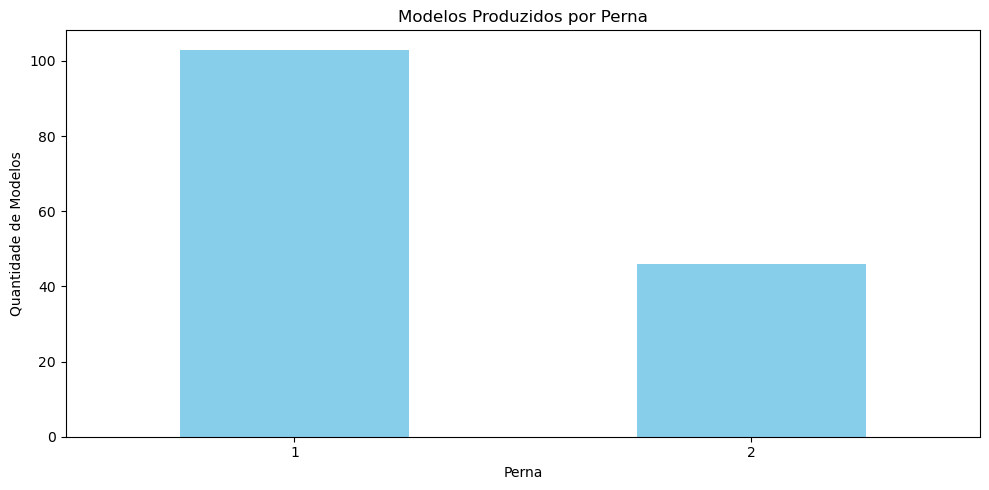

C:\Users\User\AppData\Local\Temp\ipykernel_11940\3497704547.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(modelos_produzidos.index, rotation=45)
C:\Users\User\AppData\Local\Temp\ipykernel_11940\2126072313.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(media_perna.index, rotation=45)
C:\Users\User\AppData\Local\Temp\ipykernel_11940\2126072313.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(media_perna.index, rotation=45)
C:\Users\User\AppData\Local\Temp\ipykernel_11940\4282426640.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_num = pivot.applymap(lambda x: modelo_to_int.get(x, np.nan))


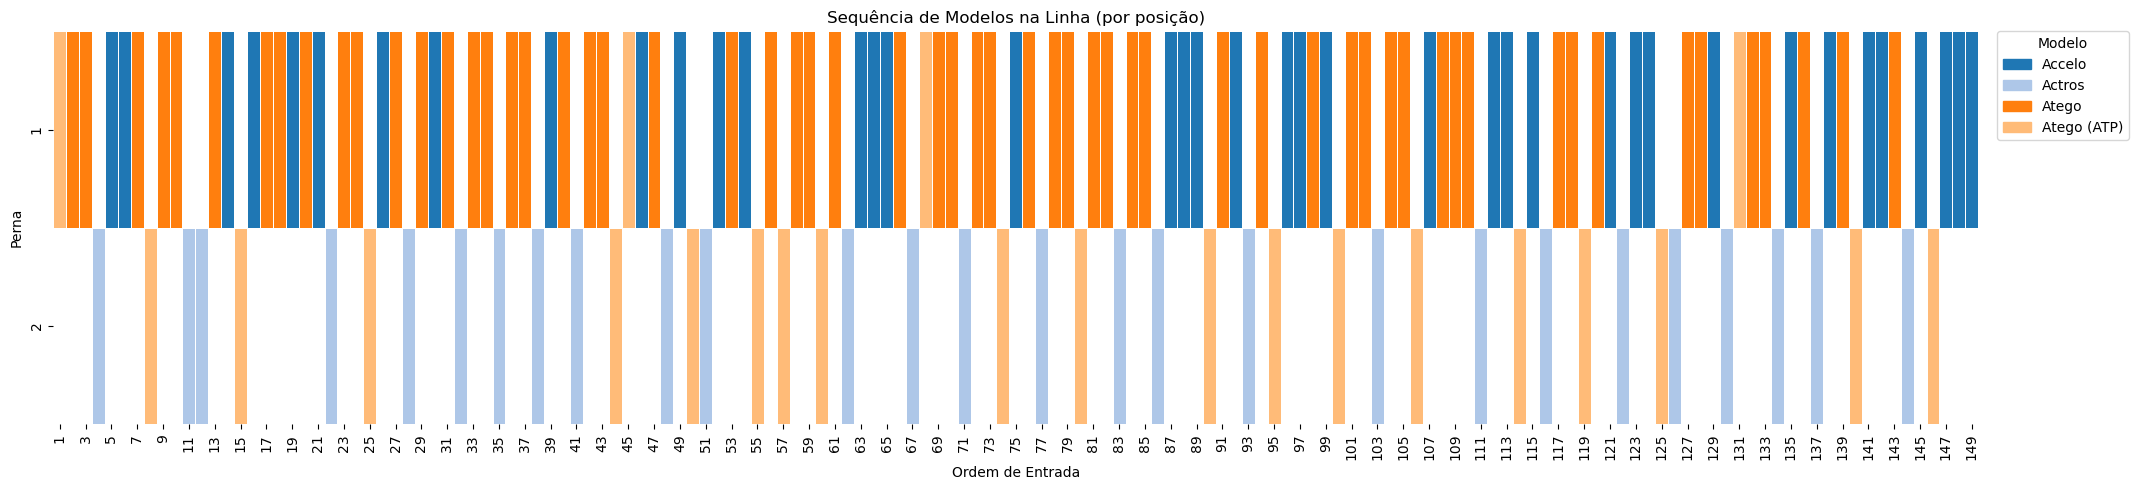

📁 Log salvo em: logs_C2/2025-04-10/log_2025-04-10.csv
📝 PDF salvo em: logs_C2/2025-04-10/resumo_simulacao.pdf

🔄 Processando o dia: 2025-04-11
Primeiros registros do dia ordenados:
       Data Entrada Linha         Baumuster Baumuster_7dig
12373 2025-04-11 05:50:36  C9511041239 1017        C951104
33740 2025-04-11 05:56:53  C9511041246 1017        C951104
27327 2025-04-11 06:01:18       C9515011268        C951501
3605  2025-04-11 06:06:30  C9515111248 2433        C951511
14525 2025-04-11 06:13:02  C9634241215 2651        C963424
16620 2025-04-11 06:17:48       C9515011268        C951501
3606  2025-04-11 06:26:00    C96840312 1932        C968403
10150 2025-04-11 06:31:03       C9515111274        C951511
3607  2025-04-11 06:36:02       C9515111274        C951511
33742 2025-04-11 06:41:02  C9511111246 1317        C951111


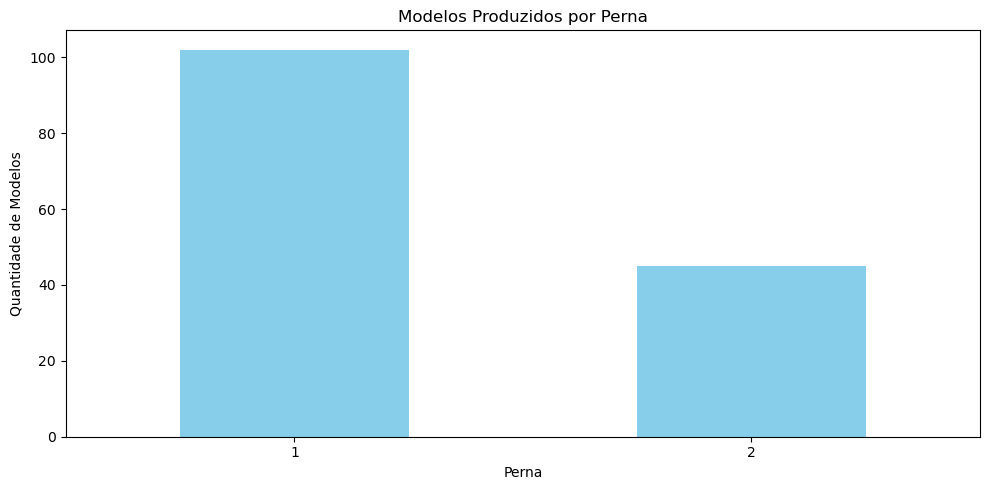

C:\Users\User\AppData\Local\Temp\ipykernel_11940\3497704547.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(modelos_produzidos.index, rotation=45)
C:\Users\User\AppData\Local\Temp\ipykernel_11940\2126072313.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(media_perna.index, rotation=45)
C:\Users\User\AppData\Local\Temp\ipykernel_11940\2126072313.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(media_perna.index, rotation=45)
C:\Users\User\AppData\Local\Temp\ipykernel_11940\4282426640.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_num = pivot.applymap(lambda x: modelo_to_int.get(x, np.nan))


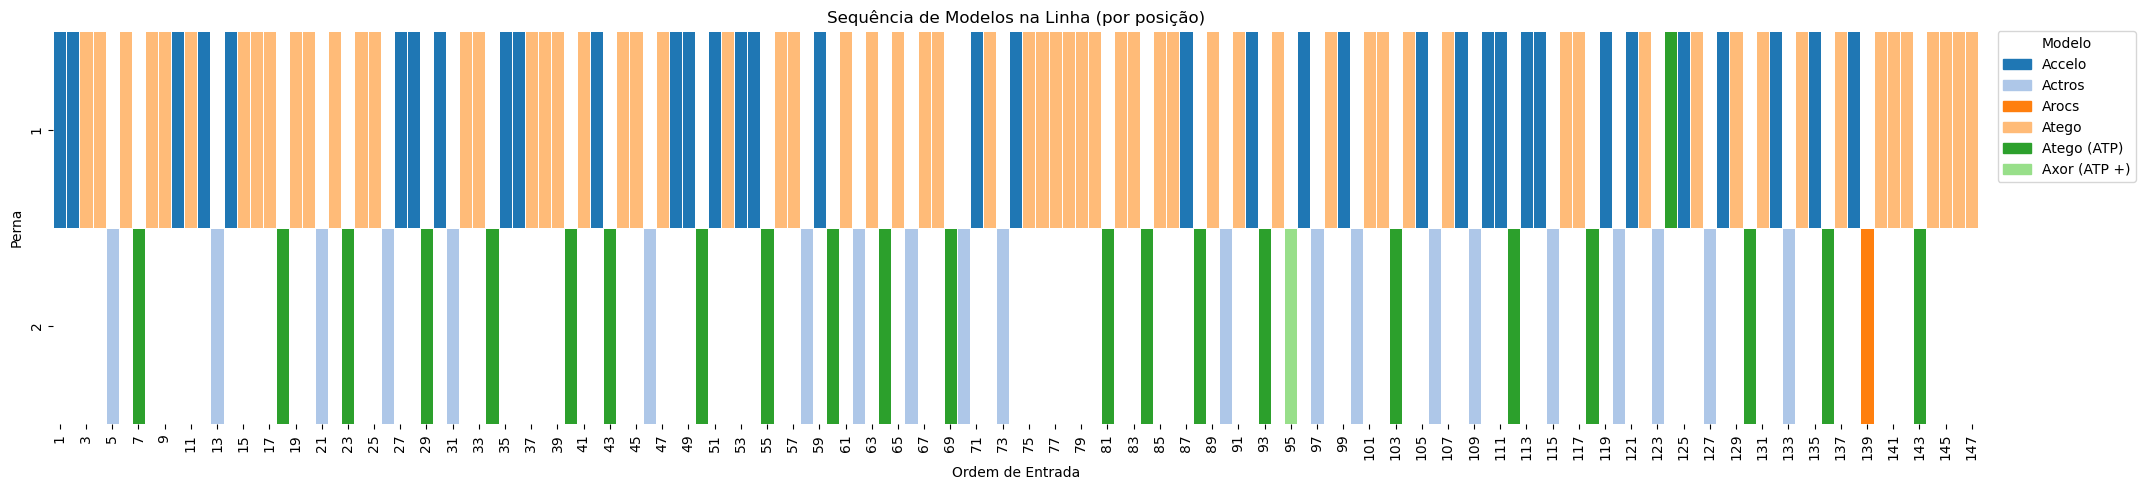

📁 Log salvo em: logs_C2/2025-04-11/log_2025-04-11.csv
📝 PDF salvo em: logs_C2/2025-04-11/resumo_simulacao.pdf

🔄 Processando o dia: 2025-04-14
Primeiros registros do dia ordenados:
       Data Entrada Linha         Baumuster Baumuster_7dig
25344 2025-04-14 05:47:26  C9511111239 1317        C951111
16788 2025-04-14 05:53:42    C96840312 1932        C968403
1589  2025-04-14 06:00:28  C9511041246 1017        C951104
8118  2025-04-14 06:08:05  C9634251233 2545        C963425
31732 2025-04-14 06:13:46  C9515011268 1726        C951501
27502 2025-04-14 06:18:59  C9511041246 1017        C951104
10296 2025-04-14 06:25:12    C96840312 1932        C968403
1415  2025-04-14 06:30:50  C9515011268 1721        C951501
16789 2025-04-14 06:37:22       C9515111274        C951511
16790 2025-04-14 06:46:54  C9511041239 1017        C951104


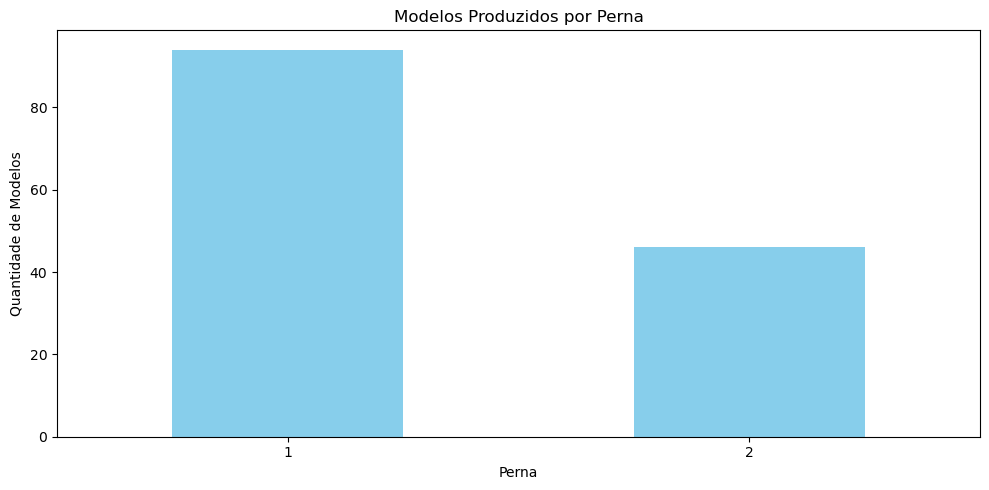

C:\Users\User\AppData\Local\Temp\ipykernel_11940\3497704547.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(modelos_produzidos.index, rotation=45)
C:\Users\User\AppData\Local\Temp\ipykernel_11940\2126072313.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(media_perna.index, rotation=45)
C:\Users\User\AppData\Local\Temp\ipykernel_11940\2126072313.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(media_perna.index, rotation=45)
C:\Users\User\AppData\Local\Temp\ipykernel_11940\4282426640.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_num = pivot.applymap(lambda x: modelo_to_int.get(x, np.nan))


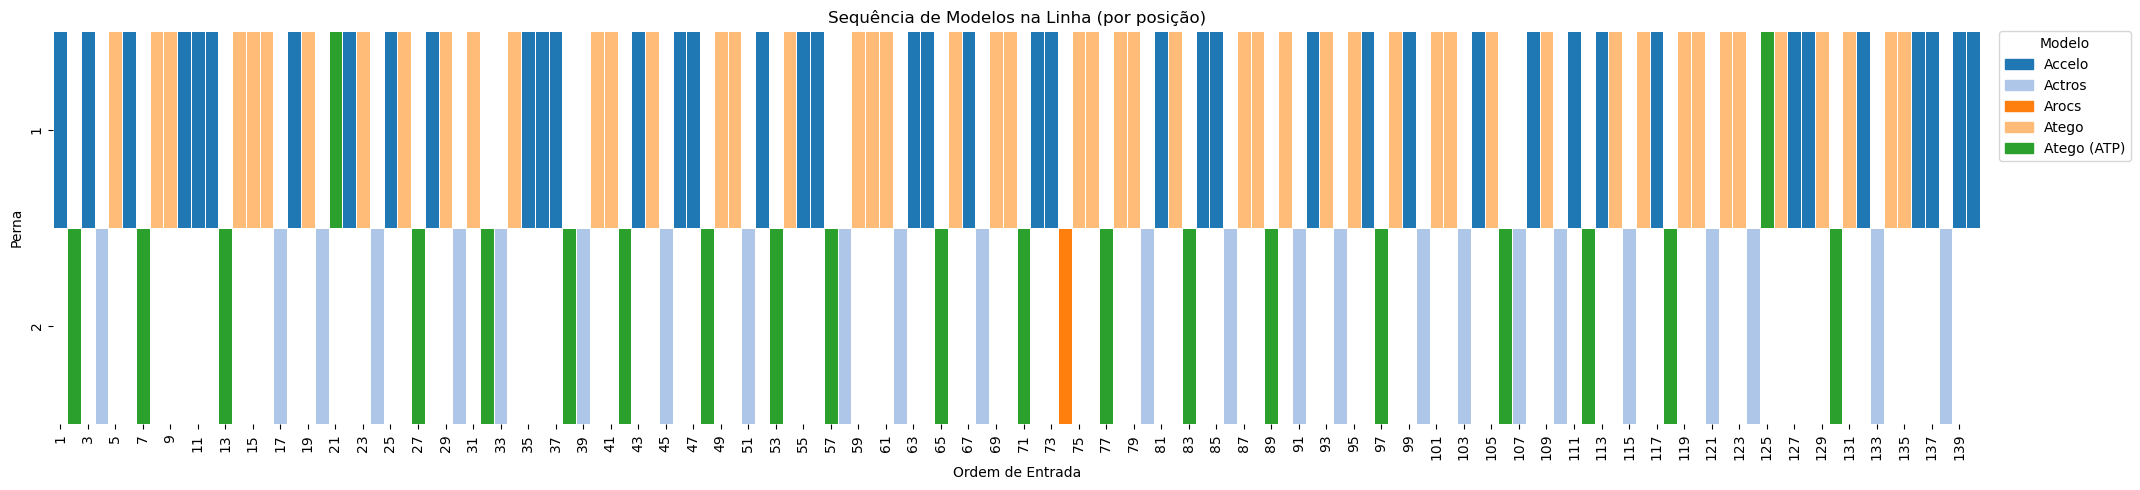

📁 Log salvo em: logs_C2/2025-04-14/log_2025-04-14.csv
📝 PDF salvo em: logs_C2/2025-04-14/resumo_simulacao.pdf

🔄 Processando o dia: 2025-04-15
Primeiros registros do dia ordenados:
       Data Entrada Linha         Baumuster Baumuster_7dig
6075  2025-04-15 05:47:25  C9511041239 1017        C951104
10438 2025-04-15 05:55:39  C9634251233 2545        C963425
25477 2025-04-15 06:00:49       C9515111278        C951511
8259  2025-04-15 06:06:45   C9511021239 817        C951102
6076  2025-04-15 06:15:05    C96840312 1932        C968403
27630 2025-04-15 06:20:25  C9515441263 3033        C951544
23090 2025-04-15 06:26:58  C9515011268 1721        C951501
10439 2025-04-15 06:44:28  C9511111239 1317        C951111
27631 2025-04-15 06:50:17    C96341412 2653        C963414
8260  2025-04-15 06:55:16       C9515011268        C951501


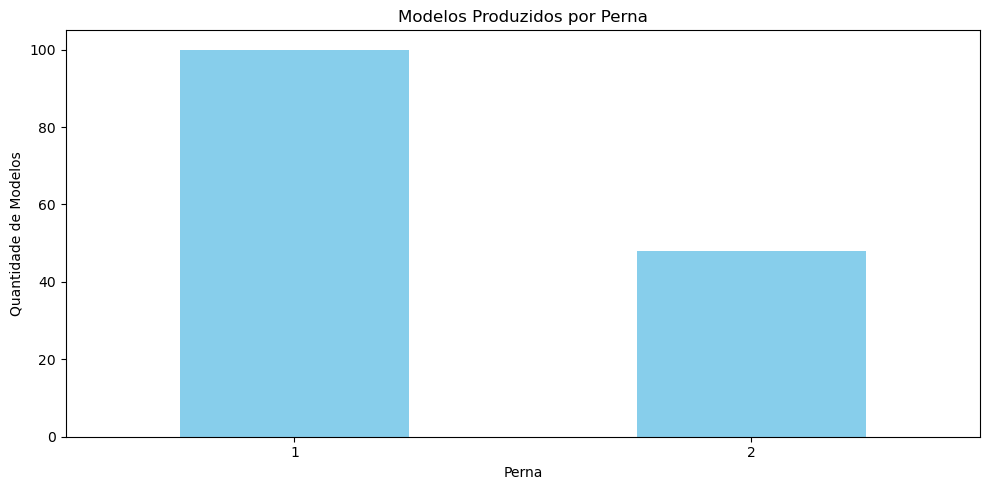

C:\Users\User\AppData\Local\Temp\ipykernel_11940\3497704547.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(modelos_produzidos.index, rotation=45)
C:\Users\User\AppData\Local\Temp\ipykernel_11940\2126072313.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(media_perna.index, rotation=45)
C:\Users\User\AppData\Local\Temp\ipykernel_11940\2126072313.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(media_perna.index, rotation=45)
C:\Users\User\AppData\Local\Temp\ipykernel_11940\4282426640.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_num = pivot.applymap(lambda x: modelo_to_int.get(x, np.nan))


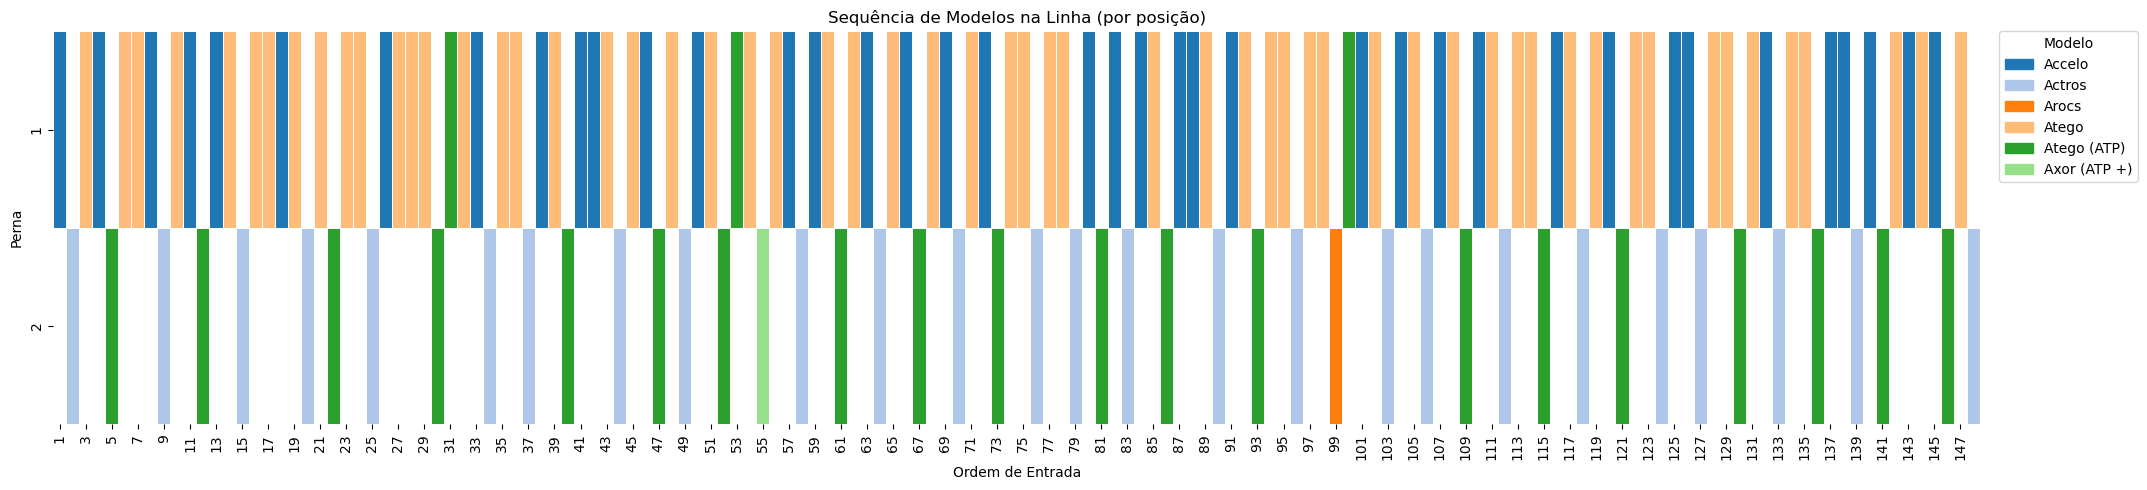

📁 Log salvo em: logs_C2/2025-04-15/log_2025-04-15.csv
📝 PDF salvo em: logs_C2/2025-04-15/resumo_simulacao.pdf

🔄 Processando o dia: 2025-04-16
Primeiros registros do dia ordenados:
       Data Entrada Linha         Baumuster Baumuster_7dig
23489 2025-04-16 05:47:24  C9511041246 1017        C951104
12803 2025-04-16 06:03:34  C9511111246 1317        C951111
29905 2025-04-16 06:09:58         C96811412        C968114
9910  2025-04-16 06:14:53  C9634251233 2545        C963425
8380  2025-04-16 06:23:54  C9515141236 2730        C951514
17014 2025-04-16 06:33:52   C9511021239 817        C951102
27719 2025-04-16 06:40:30  C9640161215 3351        C964016
4027  2025-04-16 06:46:00       C9515111274        C951511
31993 2025-04-16 06:50:30   C9511021246 817        C951102
27717 2025-04-16 06:56:03  C9634251233 2545        C963425


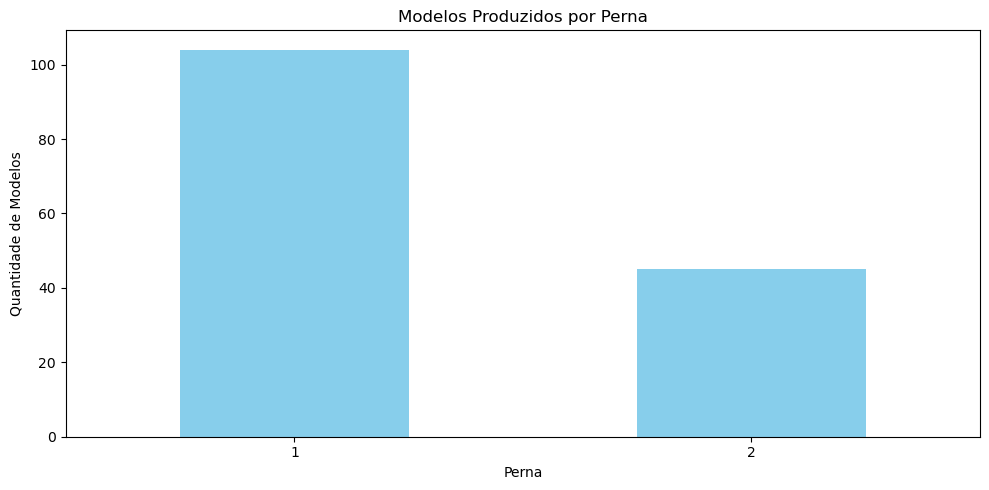

C:\Users\User\AppData\Local\Temp\ipykernel_11940\3497704547.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(modelos_produzidos.index, rotation=45)
C:\Users\User\AppData\Local\Temp\ipykernel_11940\2126072313.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(media_perna.index, rotation=45)
C:\Users\User\AppData\Local\Temp\ipykernel_11940\2126072313.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(media_perna.index, rotation=45)
C:\Users\User\AppData\Local\Temp\ipykernel_11940\4282426640.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_num = pivot.applymap(lambda x: modelo_to_int.get(x, np.nan))


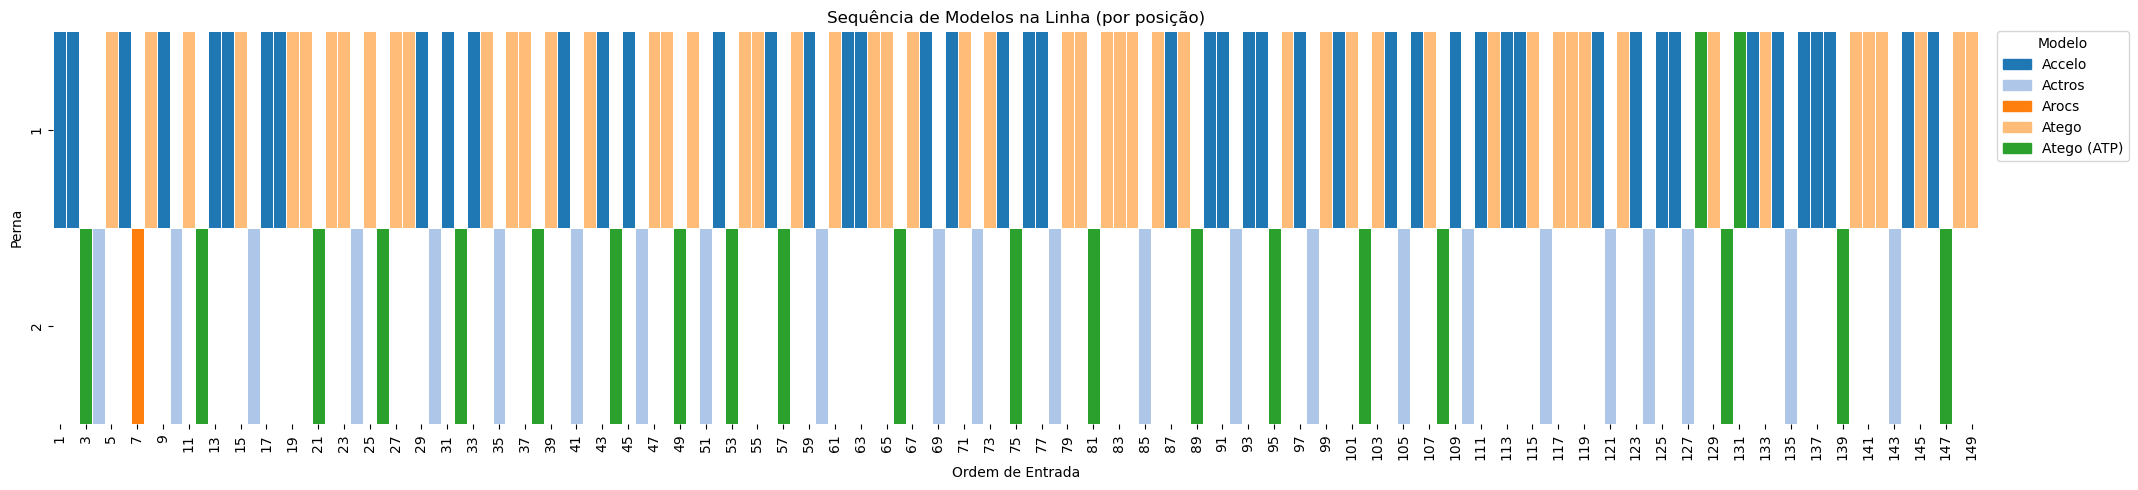

📁 Log salvo em: logs_C2/2025-04-16/log_2025-04-16.csv
📝 PDF salvo em: logs_C2/2025-04-16/resumo_simulacao.pdf


In [38]:

# Lê o arquivo Excel com os dados de produção
df_sequencia = pd.read_excel("sequencias_entrada_linha.xlsx")

# Converte a coluna de data/hora
df_sequencia['Data Entrada Linha'] = pd.to_datetime(df_sequencia['Data Entrada Linha'], errors='coerce')

# Define data de início (ajuste conforme necessário!)
data_inicio = date(2025, 4, 10)

# Obtém os dias únicos ordenados
dias_unicos = sorted(df_sequencia['Data Entrada Linha'].dt.date.dropna().unique())

# Filtra os dias a partir da data de início e pega os N primeiros
N_DIAS = 5
dias_filtrados = [d for d in dias_unicos if d >= data_inicio][:N_DIAS]

print(f"🗓️ Dias selecionados ({N_DIAS} a partir de {data_inicio}):")
for d in dias_filtrados:
    print(f"  - {d}")

# Cria pasta principal se não existir
os.makedirs("logs_C2", exist_ok=True)

# Salvando tempo por atividades
figs = plot_tempo_atividades_por_modelo(MODELOS_CSV, ATIVIDADES_P1, ATIVIDADES_P2, get_process_times_from_csv)
for i, fig in enumerate(figs, start=1):
    fig.savefig(f"logs_C2/atividades_modelo{i}.png", dpi=300, bbox_inches="tight")
    plt.close(fig)

# Loop por dia
for dia in dias_filtrados:
    log_entrada_saida = []
    print(f"\n🔄 Processando o dia: {dia}")
    
    pasta_dia = f"logs_C2/{dia}"
    nome_csv = f"{pasta_dia}/log_{dia}.csv"

    # Se já tiver o CSV salvo, pula o dia
    if os.path.exists(nome_csv):
        print(f"✅ Já processado: {dia}")
        continue

    os.makedirs(pasta_dia, exist_ok=True)

    # --------- 🔧 AQUI ESTÁ A MUDANÇA IMPORTANTE ---------
    # Filtra dados do dia e ORDENA por Data Entrada Linha (data+hora)
    df_dia = (
        df_sequencia[df_sequencia['Data Entrada Linha'].dt.date == dia]
        .copy()
        .sort_values('Data Entrada Linha', ascending=True)
    )

    # Extrai os 7 primeiros dígitos do Baumuster (removendo espaços perdidos)
    df_dia['Baumuster_7dig'] = df_dia['Baumuster'].astype(str).str.strip().str[:7]

    # Agora a sequência está na ordem correta (crescente por horário daquele dia)
    sequencia_modelos = df_dia['Baumuster_7dig'].tolist()
    # ------------------------------------------------------

    # (Opcional) print de conferência
    print("Primeiros registros do dia ordenados:")
    print(df_dia[['Data Entrada Linha', 'Baumuster', 'Baumuster_7dig']].head(10))

    # Simula
    df_log = simulacao_linha(sequencia_modelos, MODELOS_CSV, POSTOS, TAKT_TIME, TURN_DURATION)

    # Gráficos e salvamento
    fig1 = plot_modelos_por_perna(df_log)
    fig1.savefig(f"{pasta_dia}/modelos_por_perna.png", dpi=300, bbox_inches="tight")
    plt.close(fig1)

    fig2 = plot_modelos_produzidos(df_log)
    fig2.savefig(f"{pasta_dia}/modelos_produzidos.png", dpi=300, bbox_inches="tight")
    plt.close(fig2)

    figs = plot_ocupacao_por_modelo_heatmap(df_log, TURN_DURATION)
    for i, fig in enumerate(figs, start=1):
        fig.savefig(f"{pasta_dia}/ocupacao_modelo_posto_P{i}.png", dpi=300, bbox_inches="tight")
        plt.close(fig)
    
    figs = plot_duracao_media_por_posto(df_log)
    for i, fig in enumerate(figs, start=1):
        fig.savefig(f"{pasta_dia}/duracao_media_por_posto_P{i}.png", dpi=300, bbox_inches="tight")
        plt.close(fig)

    fig5 = plot_sequencia_modelos_heatmap(df_log)
    fig5.savefig(f"{pasta_dia}/sequencia_dia.png", dpi=300, bbox_inches='tight')
    plt.close(fig5)

    # fig6 = plot_boxplot_tempo_total_por_modelo(df_log)
    # fig6.savefig(f"{pasta_dia}/boxplot_tempo_total_por_modelo.png", dpi=300, bbox_inches='tight')
    # plt.close(fig6)

    # Salva CSV com o log
    df_log.to_csv(nome_csv, index=False)
    print(f"📁 Log salvo em: {nome_csv}")

    # (Opcional) Salva PDF com o resumo
    caminho_pdf = f"{pasta_dia}/resumo_simulacao.pdf"
    gerar_resumo_pdf(df_log, TURN_DURATION, caminho_pdf)